In [1]:
import glob
import numpy as np
import pandas as pd

from skelo.model.elo import EloEstimator

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=12)


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
df = pd.concat([pd.read_csv(x) for x in glob.glob('/home/daniel/wizepair2/elo_training-*.gz')])

In [4]:
df.publication_date_greatest = pd.to_datetime(df.publication_date_greatest)
df.sort_values('publication_date_greatest', inplace=True)
df.reset_index(inplace=True, drop=True)

In [5]:
df['label'] = df.standard_change=='increase'

In [6]:
df.head(3)

,wizepair2_uuid,assay_id,standard_type,standard_change,publication_date_greatest,fragment_md5_1,fragment_md5_2,radius,tid,rating_uuid,rating_partition,label
0,9d135165ed18fbb35b60b766116eeec1,688583,Potency,no-change,1970-01-01,97b841ff1304769eeb4cbad2e9871882,e6863c78309033197c72682044aeae58,3,103686,8b95504d87ec14fec3184a9dee94bd04,8,False
1,c7d5b86628168b15b1ab4bee80abc458,1915140,IC50,increase,1970-01-01,a22b7948e5dfc19057bf9d532f44bd36,49abb5f9bd529b643d284fdd1b21d927,1,22226,1985c899f635714177bf6cc94bfeed0b,8,True
2,cc4fa1401b46c90c16a97de310a32968,688794,Potency,increase,1970-01-01,940ba680c81a6edd3106b2cdbfd75355,8e118d094cf9abeb4d62c760b74886c6,4,105104,465e0ec54ec989364408d86c4b5f72be,8,True


In [7]:
df.publication_date_greatest.quantile([0, 0.05, 0.5, 0.95, 1])

0.00   1970-01-01
0.05   1989-03-05
0.50   2009-01-12
0.95   2018-09-25
1.00   2020-11-28
Name: publication_date_greatest, dtype: datetime64[ns]

In [8]:
len(df.index)

19289514

In [11]:
def elo(df, return_ratings=False):
    
    # create a table where winner / loser is defined
    if df.empty: return None
    
    # fit model
    model = EloEstimator(
        key1_field="fragment_md5_1",
        key2_field="fragment_md5_2",
        timestamp_field="publication_date_greatest",
        initial_time=pd.to_datetime('1970-01-01'),
        default_k=20
    ).fit(df, df.label)
    if return_ratings: return model.rating_model.to_frame()

    # calculate proba
    df['proba'] = model.transform(df, output_type='prob', strict_past_data=True)
    return df[['assay_id', 'rating_uuid', 'proba', 'label']]
    

In [12]:
df_elo = df.groupby(['standard_type', 'tid', 'radius']).parallel_apply(elo)

In [13]:
df_elo.proba.quantile([0, 0.1, 0.5, 0.9, 1])

0.0    0.000001
0.1    0.471648
0.5    0.500000
0.9    0.528705
1.0    0.999999
Name: proba, dtype: float64

In [14]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_elo.label, df_elo.proba)

0.5702030458088644

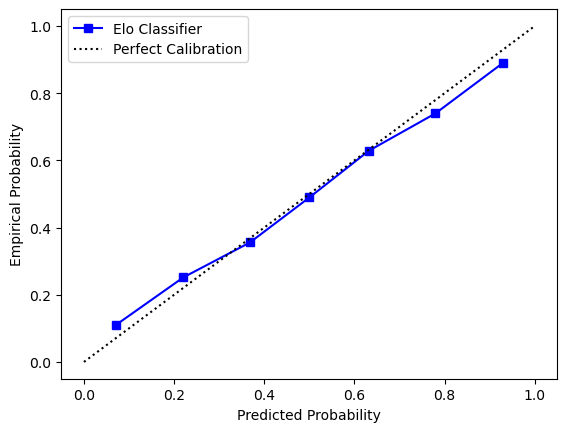

In [15]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  df_elo.label,
  df_elo.proba,
  n_bins=7
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

In [16]:
df_elo.sort_values('proba', ascending=False)

assay_id  \
standard_type tid   radius                      
Ki            10193 4      16544697   1552240   
                           17563398   1685271   
                           17246279   1652370   
                           16805777   1563412   
                           16451540   1925022   
...                                       ...   
                           16442994   1925022   
                           16795605   1563412   
                           17232764   1652370   
                           17563808   1685271   
                           16540134   1552240   

                                                          rating_uuid  \
standard_type tid   radius                                              
Ki            10193 4      16544697  23cbf9e2b4f651ca682e3bd726525418   
                           17563398  23cbf9e2b4f651ca682e3bd726525418   
                           17246279  23cbf9e2b4f651ca682e3bd726525418   
                           16805777  23cbf9e2b4f651ca682e3bd726525418   
                           16451540  23cbf9e2b4f651ca682e3bd726525418   
...                                                               ...   
                           16442994  91cee99067e94e426cdabb5e5767492d   
                           16795605  91cee99067e94e426cdabb5e5767492d   
                           17232764  91cee99067e94e426cdabb5e5767492d   
                           17563808  91cee99067e94e426cdabb5e5767492d   
                           16540134  91cee99067e94e426cdabb5e5767492d   

                                        proba  label  
standard_type tid   radius                            
Ki            10193 4      16544697  0.999999   True  
                           17563398  0.999998   True  
                           17246279  0.999998   True  
                           16805777  0.999998   True  
                           16451540  0.999998   True  
...                                       ...    ...  
                           16442994  0.000002  False  
                           16795605  0.000002  False  
                           17232764  0.000002  False  
                           17563808  0.000002  False  
                           16540134  0.000001  False  

[19289514 rows x 4 columns]

In [17]:
df_ratings = df.groupby(['standard_type', 'tid', 'radius']).parallel_apply(elo, return_ratings=True)

In [18]:
df_ratings.sort_values('rating', ascending=False)

key  \
standard_type tid    radius                                           
Ki            15     4      84852  0108bac7ed2929e150f65f69b9dc46b7   
                            84851  0108bac7ed2929e150f65f69b9dc46b7   
                            84850  0108bac7ed2929e150f65f69b9dc46b7   
                            84849  0108bac7ed2929e150f65f69b9dc46b7   
                            84848  0108bac7ed2929e150f65f69b9dc46b7   
...                                                             ...   
Inhibition    22226  1      20718  252a226c309990460f131702755561b9   
Ki            104764 1      88588  16b9af0a2dd2c01e22e382028af5d9f0   
                            88589  16b9af0a2dd2c01e22e382028af5d9f0   
                            88590  16b9af0a2dd2c01e22e382028af5d9f0   
Inhibition    22226  1      20720  252a226c309990460f131702755561b9   

                                        rating valid_from   valid_to  
standard_type tid    radius                                           
Ki            15     4      84852  2647.625698 2016-03-11 2016-03-11  
                            84851  2647.622096 2016-03-11 2016-03-11  
                            84850  2647.620522 2016-03-11 2016-03-11  
                            84849  2647.536917 2016-03-11 2016-03-11  
                            84848  2647.534349 2016-02-06 2016-03-11  
...                                        ...        ...        ...  
Inhibition    22226  1      20718  -132.979922 2019-03-08 2019-03-08  
Ki            104764 1      88588  -137.652019 2013-03-11 2014-01-15  
                            88589  -137.652523 2014-01-15 2014-01-15  
                            88590  -137.652950 2014-01-15 2014-01-15  
Inhibition    22226  1      20720  -142.979922 2019-03-08        NaT  

[43077668 rows x 4 columns]

In [20]:
df_ratings[df_ratings.valid_to.isna()].to_csv('/home/daniel/wizepair2/elo_ratings.csv.gz', compression='gzip')